In [1]:
%pylab inline
import seaborn as sns
import numpy as np
import xarray as xr
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
#import cmocean as cm


Populating the interactive namespace from numpy and matplotlib


/gpfs/u/apps/dav/opt/python/3.6.8/gnu/7.3.0/pkg-library/20190326/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# Generic plotting
rcParams['savefig.dpi'] = 300
rcParams['figure.figsize'] = [13, 7]
rcParams['figure.dpi'] = 300
rcParams['font.size'] = 12
rcParams['font.family'] = 'Arial'
sns.set_style("white")

# Load files

In [3]:
pathx1 = '/glade/p/cgd/oce/people/dwhitt/nsfsubmeso/WhittNicholson_data/CTL/'
pathx2 = '/glade/p/cgd/oce/people/dwhitt/nsfsubmeso/WhittNicholson_data/LP/'
xmc = xr.open_mfdataset(pathx1 + 'XMXL-all-monmean.nc', decode_times=False)
xmlp = xr.open_mfdataset(pathx2 + 'XMXL-all-monmean.nc', decode_times=False)
lon = xmc.TLONG.values
lat = xmc.TLAT.values
mld = xmc.XMXL.values/1e2
mld_lp = xmlp.XMXL.values/1e2


# Adjust grid

In [4]:
# to regrid the CESM data 
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = ni/2 - 1
    xR = xL + ni

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field
	

# DIFFERENCE AND ANNUAL MEAN DIFF:

In [5]:
mld_diff = mld - mld_lp
mld_diff_mean = np.nanmean(mld_diff,axis=0)
mld_max=np.nanmax(mld,axis=0)
mld_mean=np.nanmean(mld,axis=0)


/gpfs/u/apps/dav/opt/python/3.6.8/gnu/7.3.0/pkg-library/20190326/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/gpfs/u/apps/dav/opt/python/3.6.8/gnu/7.3.0/pkg-library/20190326/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: All-NaN slice encountered
  This is separate from the ipykernel package so we can avoid doing imports until
/gpfs/u/apps/dav/opt/python/3.6.8/gnu/7.3.0/pkg-library/20190326/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


# FIND MASKS OF LARGEST MEAN DIFF

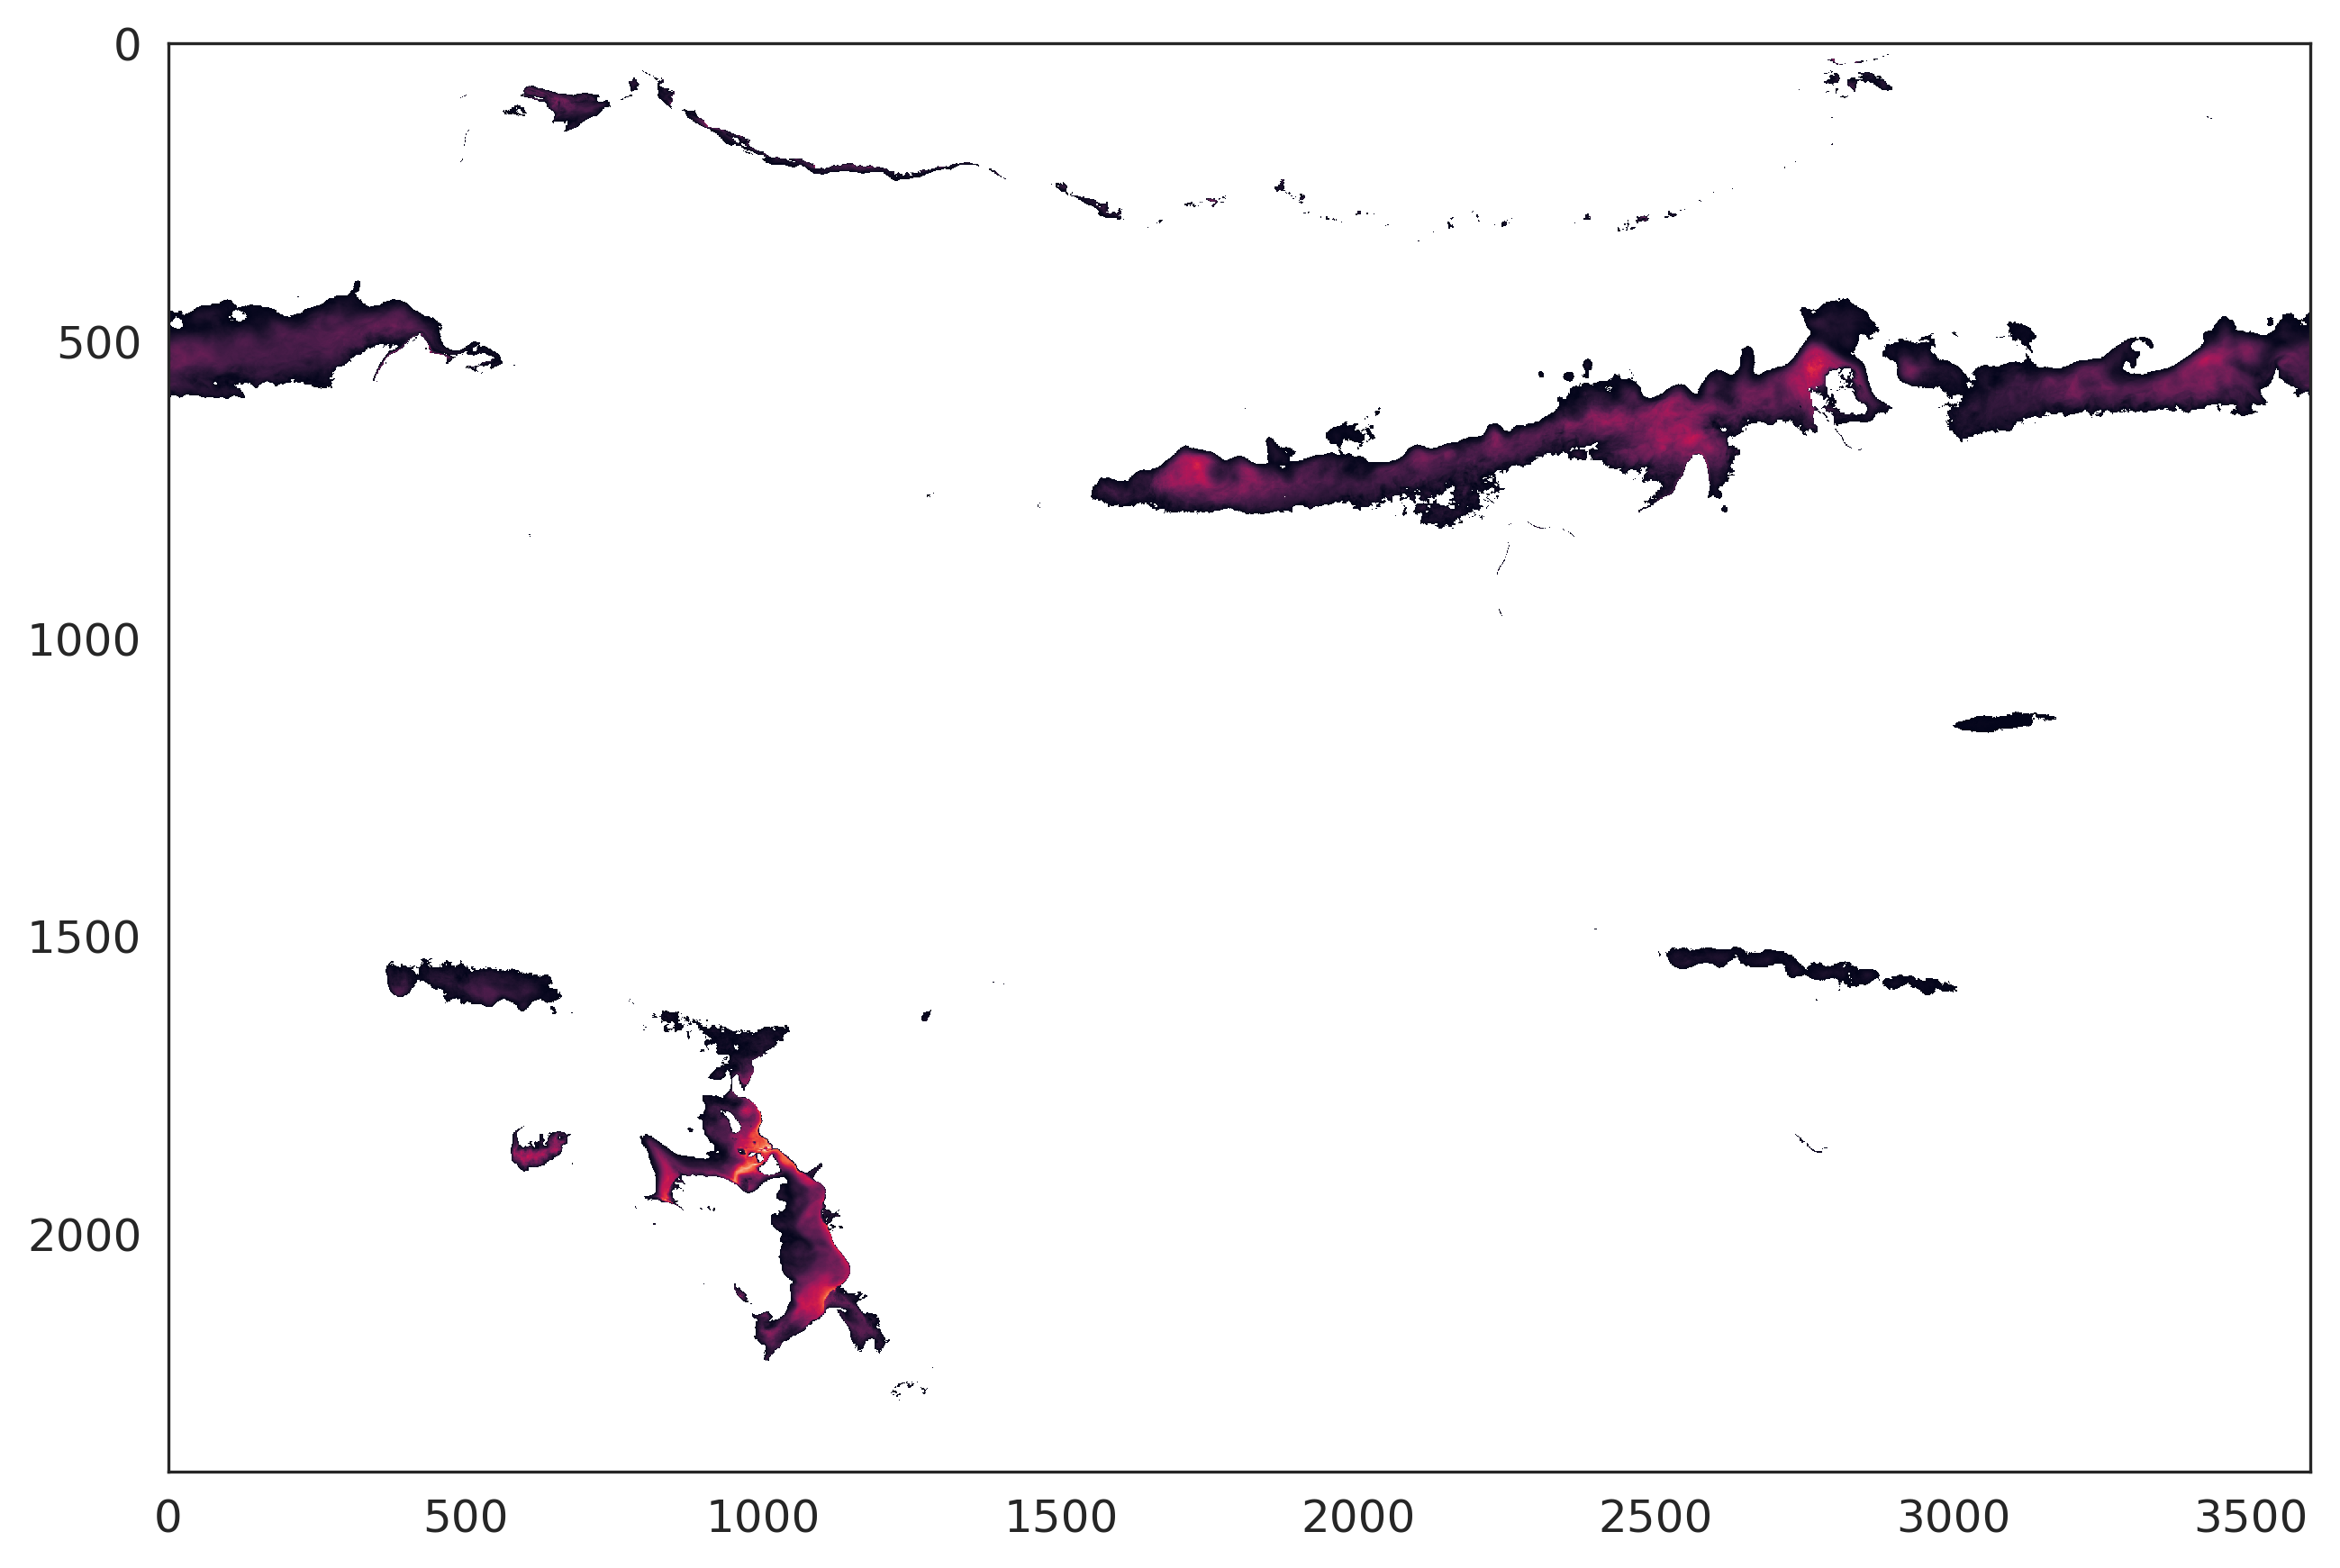

In [6]:
# 3: FIND MASK BASED ON 95 percentile on the mean:
#---------------------------
#mld_diff_mask = np.ma.masked_less_equal(mld_diff_mean, np.nanpercentile(mld_diff_mean ,90))
#mld_diff_mask = np.ma.masked_less_equal(mld_max, np.nanpercentile(mld_max ,95))
mld_diff_mask = np.ma.masked_less_equal(mld_mean, np.nanpercentile(mld_mean ,93))
imshow(mld_diff_mask)

# FIND REGIONAL MASKS

In [7]:
# 5. Mask regions:
#---------------
mask_land = np.ma.masked_greater(lon , 1e34)
mask_so = np.ma.array(((lat < -30) & (lat > -65)) & ~mld_diff_mask.mask)*1
mask_kc = np.ma.array(((lon < -130 +360 ) & (lon > -225 +360 ) & (lat >  20 ) & (lat < 45 )) & ~mld_diff_mask.mask)*2
mask_lab = np.ma.array(((lon < -42+360 ) & (lon > -66+360 ) & (lat < 65 ) & (lat > 51 ))  & ~mld_diff_mask.mask)*3  
mask_gc = np.ma.array(((lon > -85 +360) & (lon < -30 +360 ) & (lat > 20 ) & (lat < 51 ))  & ~mld_diff_mask.mask)*4  
mask_ns = np.ma.array(((lat > 50 ) & (lat < 95 ) & (lon > -40  +360) & (lon > 40 ))  & ~mld_diff_mask.mask)*5 
mask_all = np.ma.masked_equal(mask_so + mask_kc + mask_lab + mask_gc + mask_ns ,mask_land)

In [8]:
# regrid to make map plot:
plt.figure(figsize=(10,5))
lon1,lat1,mask_all1 = adjust_pop_grid(lon,lat,mask_all)

ax = plt.subplot(211, projection=ccrs.Robinson(central_longitude=0))
mm = ax.contourf(lon1,lat1,np.ma.masked_equal(mask_all1,0),np.arange(0,6,1),transform=ccrs.PlateCarree(),cmap='jet')
ax.coastlines(resolution='110m');
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',edgecolor='w',\
                                            facecolor='k'))
cbar = plt.colorbar(mm,ax=ax)
cbar.ax.set_yticklabels(['Southern Ocean','Kuroshio','Labrador Sea','Gulf Stream','Norwegian Sea'])

TypeError: slice indices must be integers or None or have an __index__ method

<Figure size 3000x1500 with 0 Axes>

# SAVE NETCDF

In [9]:
la,lo = np.shape(mask_so)
#nc.close()
from netCDF4 import Dataset
root_grp = Dataset('regional_mask_all1.nc', 'w', format='NETCDF4')
root_grp.description = 'Masks of regional hostspots in top 5\% of annual max MLD'
root_grp.createDimension('lon', lo)
root_grp.createDimension('lat', la)

# variables
mask_alls = root_grp.createVariable('mask_hotspots','f8' ,dimensions=('lat','lon'),fill_value=9.969209968386869e+36)
# data
root_grp.variables['mask_hotspots'][:] = mask_all
root_grp.close()  # close the new file

#mask_alls[:] = mask_all

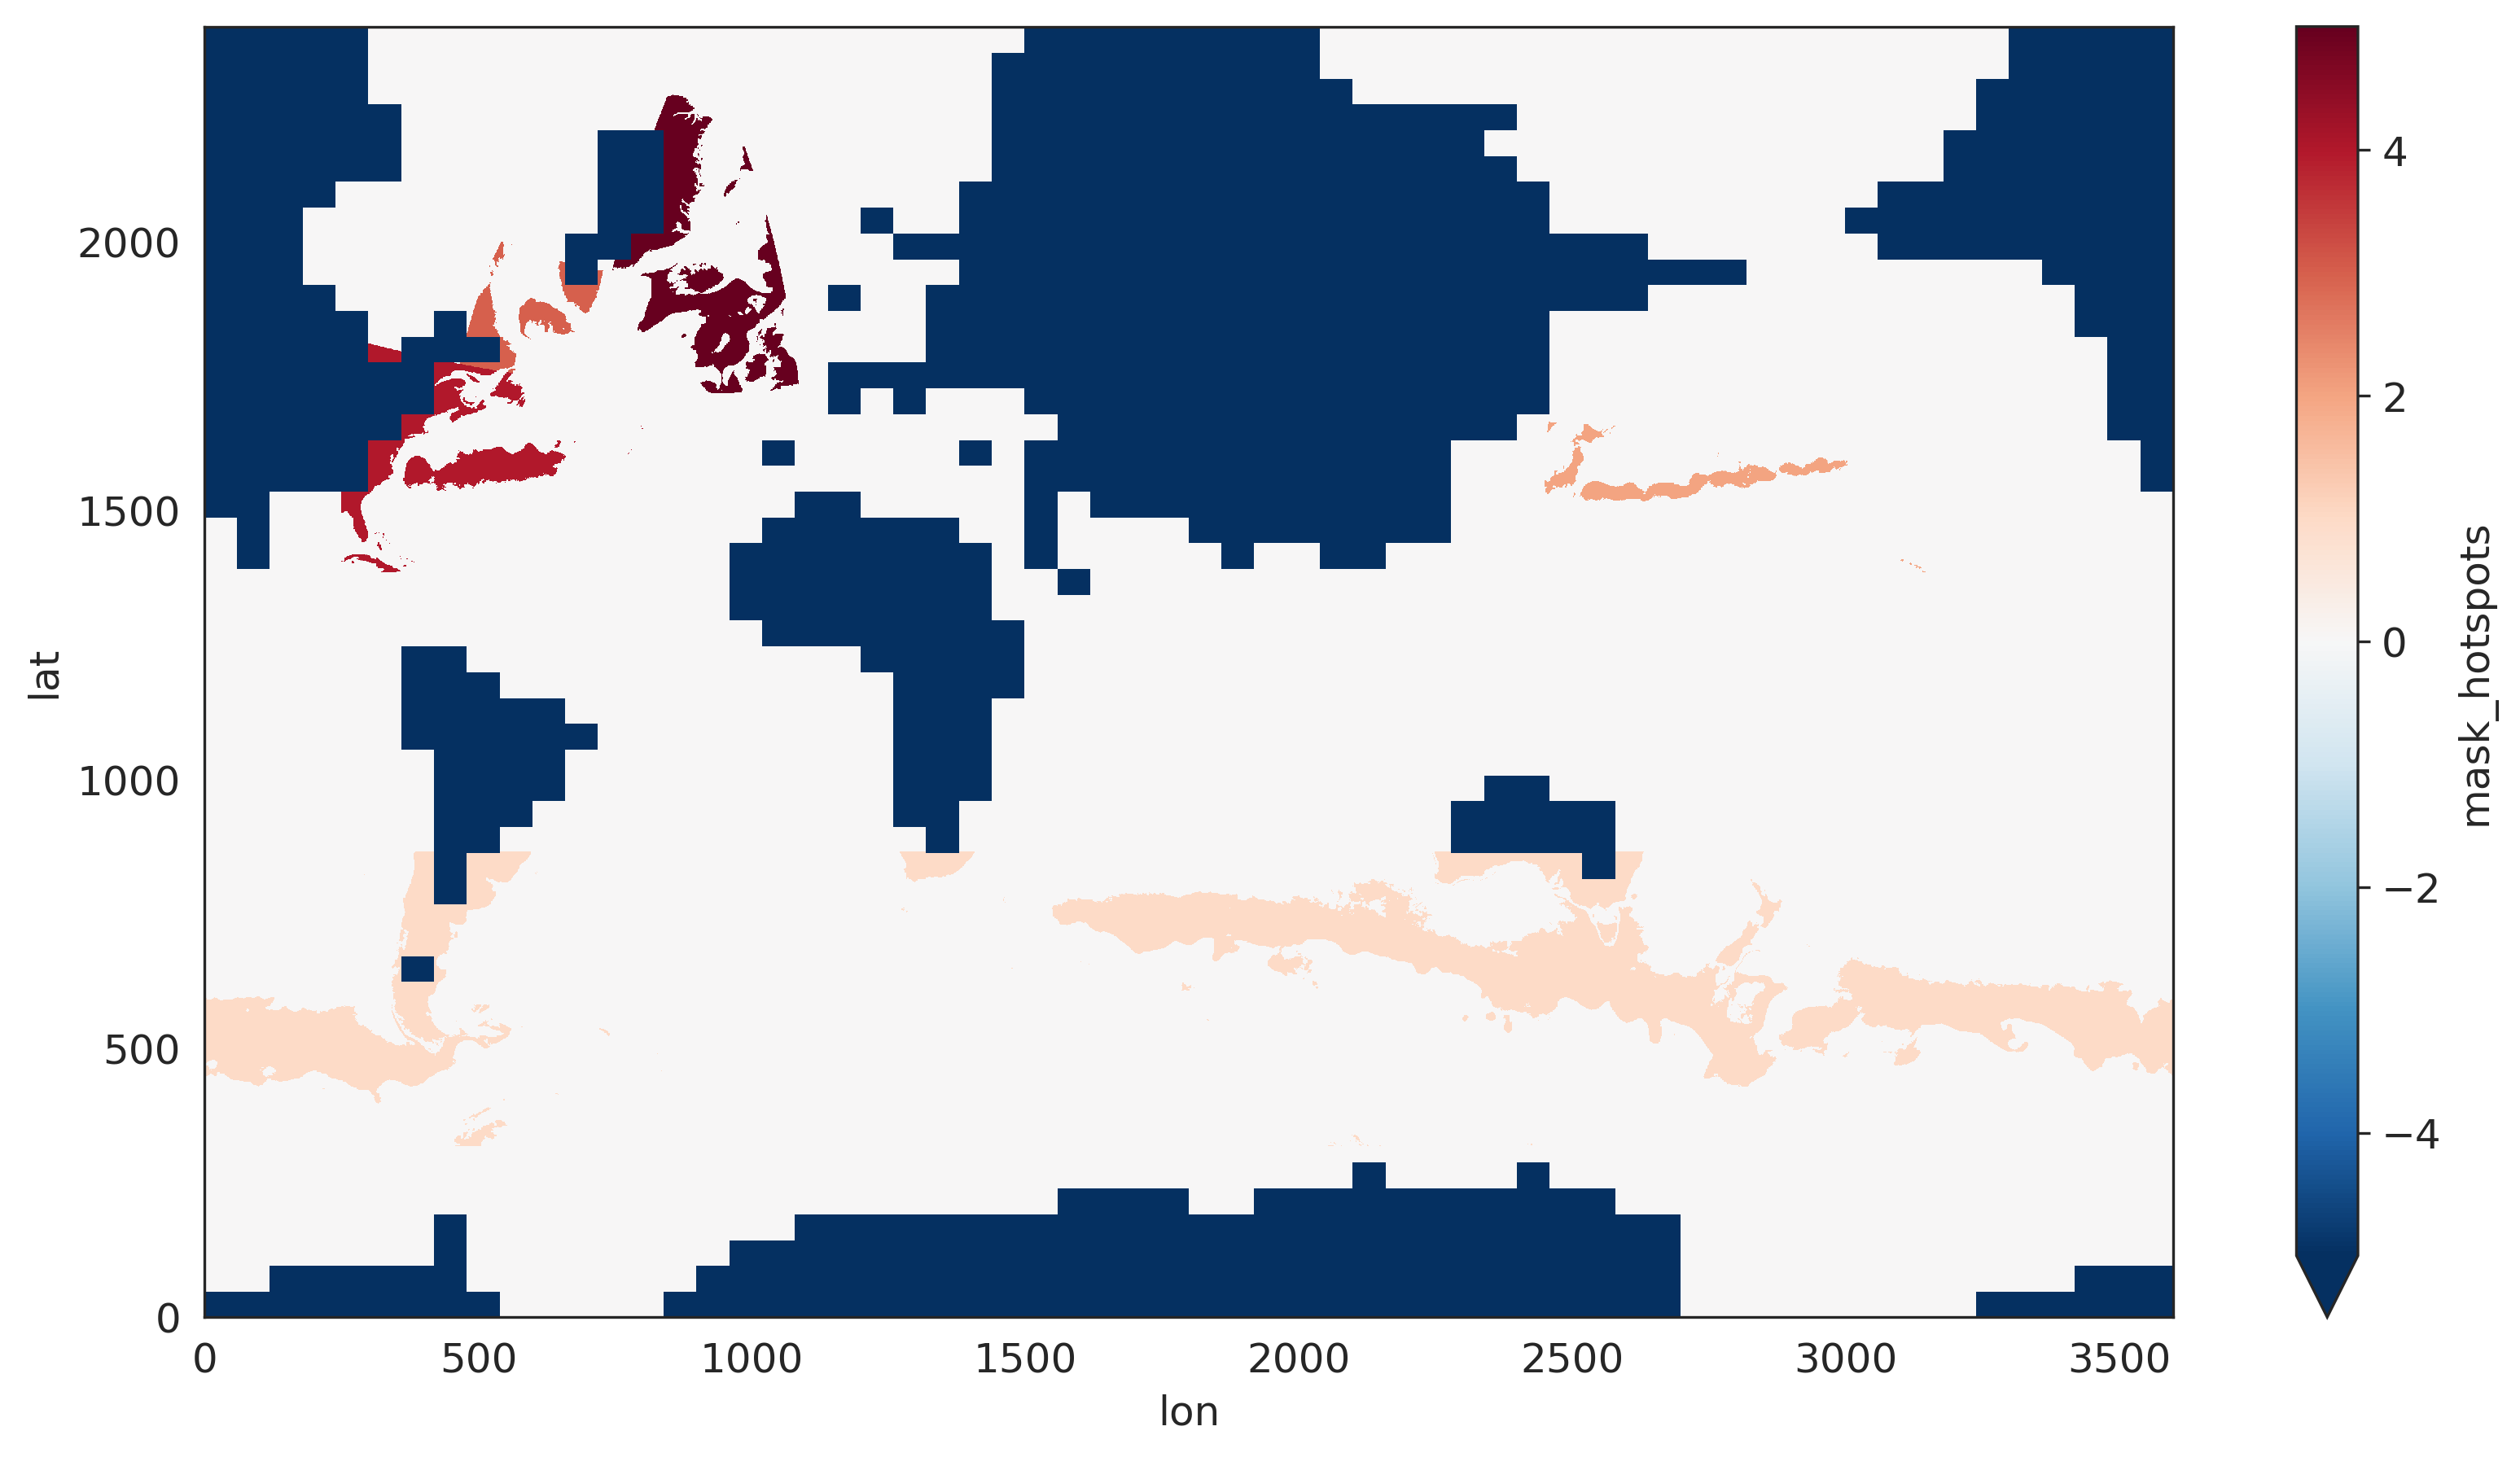

In [10]:
# Test NETCDF SAVED
test = xr.open_mfdataset('regional_mask_all1.nc', decode_times=False,)
test.mask_hotspots.plot(vmax=5)


# MASK MONTHLY MEANS and PLOT: 


/gpfs/u/apps/dav/opt/python/3.6.8/gnu/7.3.0/pkg-library/20190326/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/gpfs/u/apps/dav/opt/python/3.6.8/gnu/7.3.0/pkg-library/20190326/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/gpfs/u/apps/dav/opt/python/3.6.8/gnu/7.3.0/pkg-library/20190326/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/gpfs/u/apps/dav/opt/python/3.6.8/gnu/7.3.0/pkg-library/20190326/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice


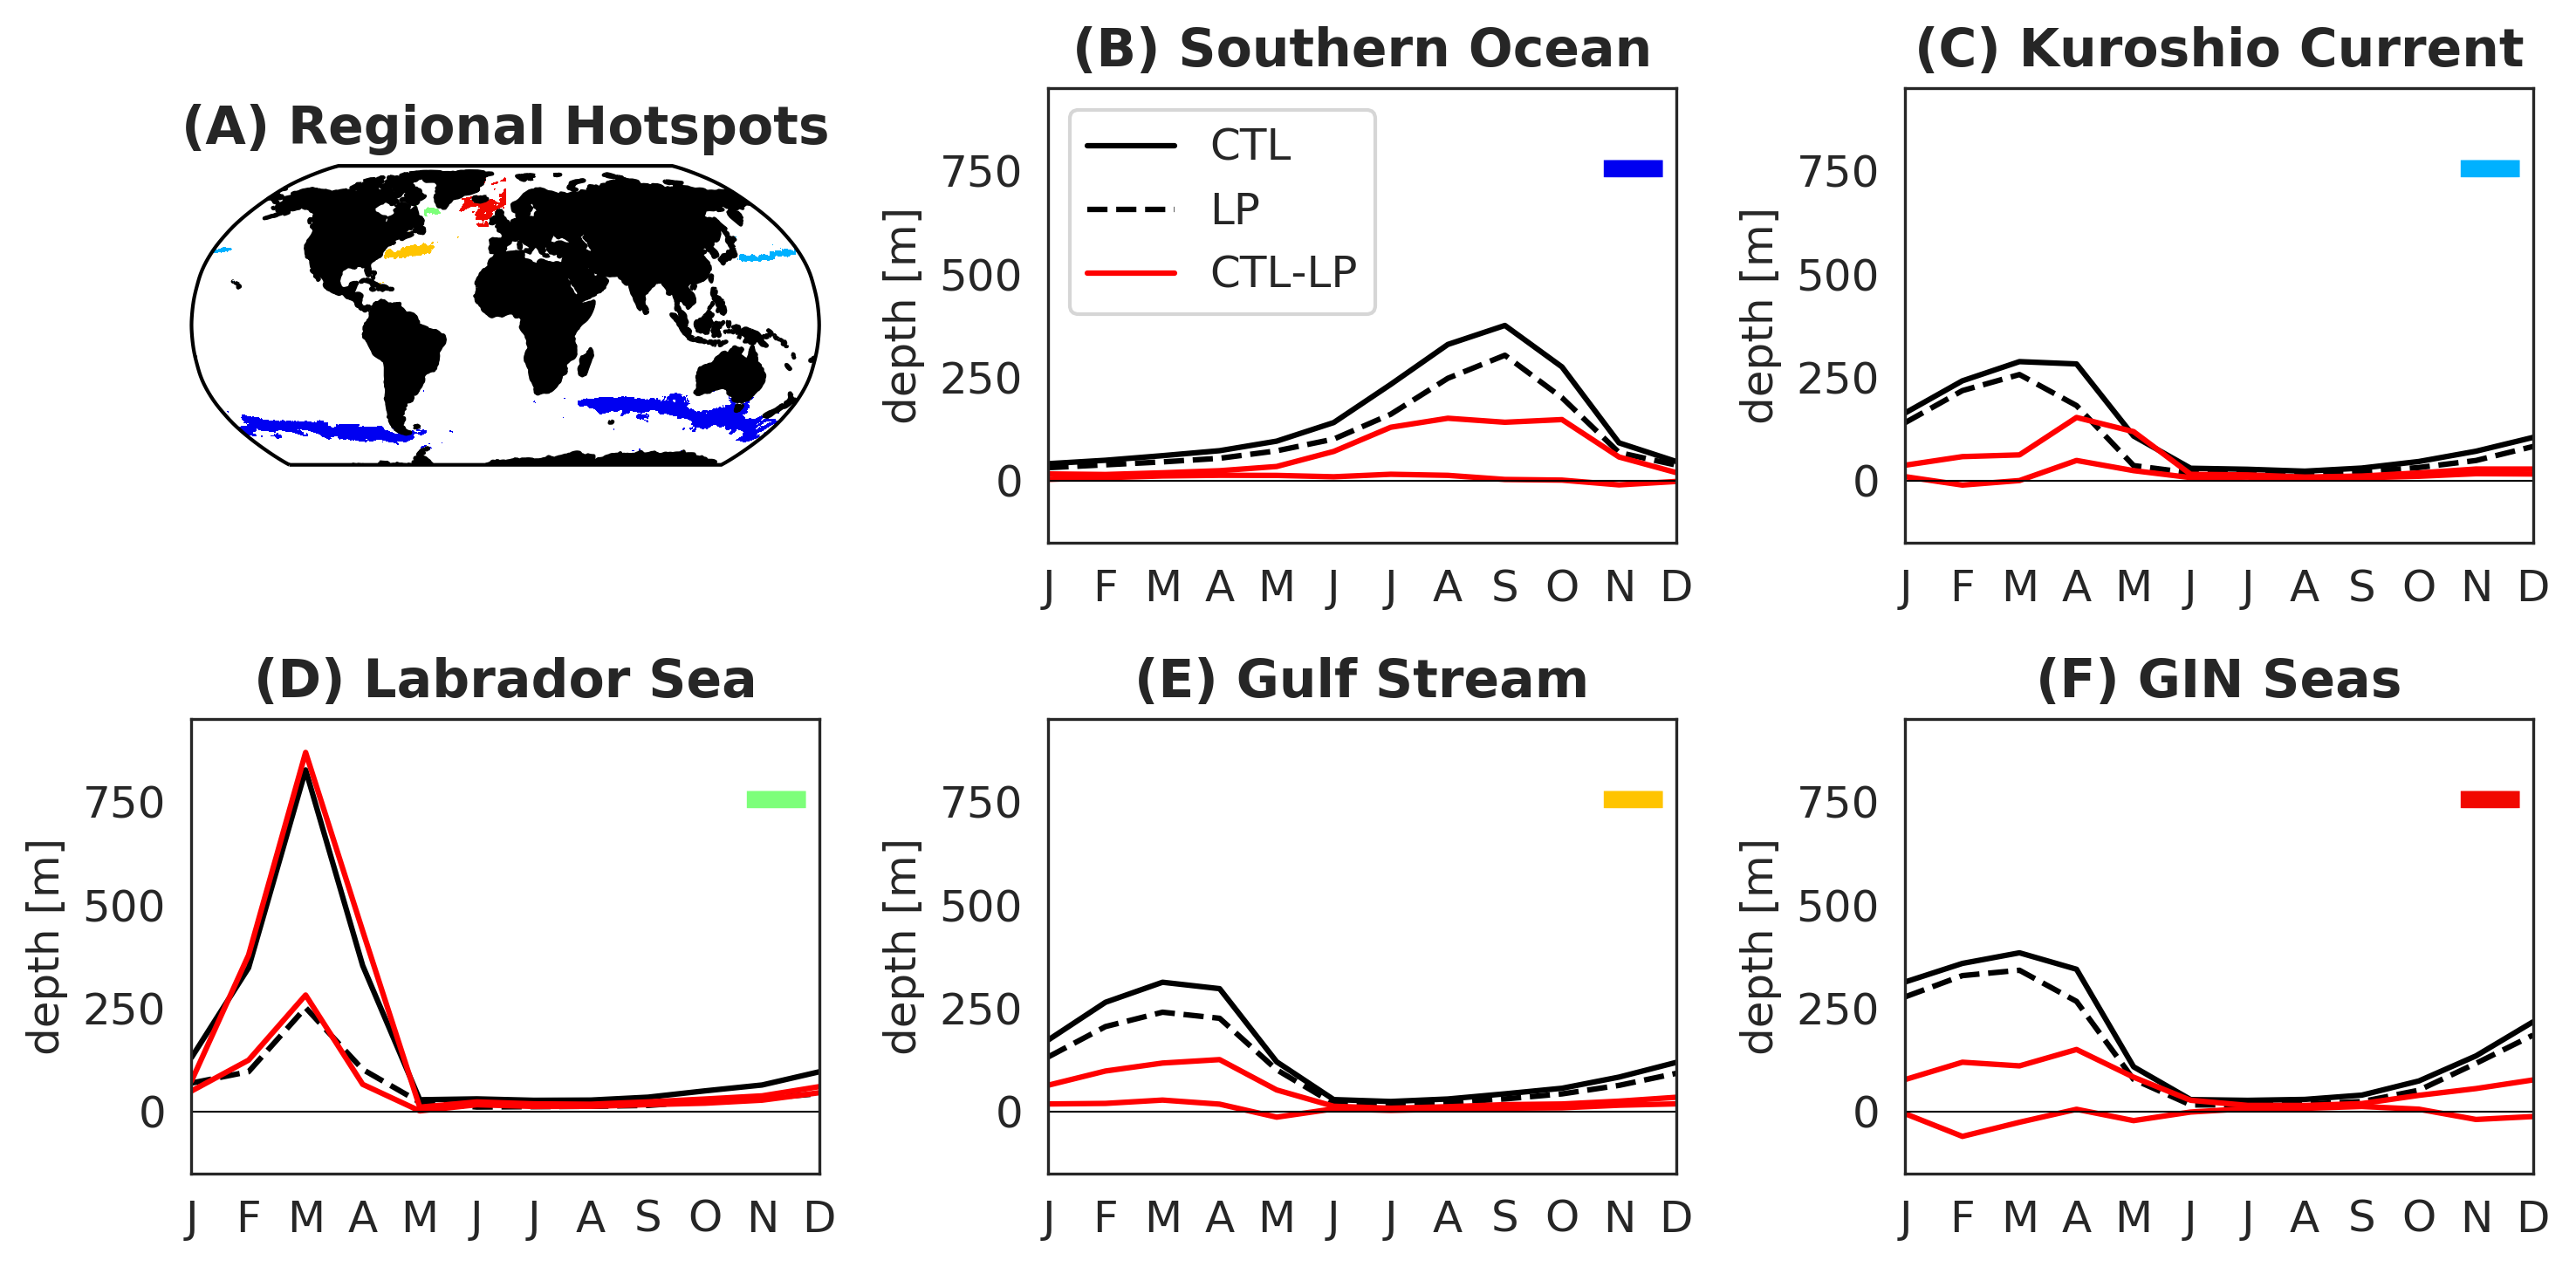

In [11]:
plt.figure(figsize(10,5))

# plot map
ax = plt.subplot(231, projection=ccrs.Robinson(central_longitude=0))
mm = ax.contourf(lon,lat,np.ma.masked_equal(mask_all,0),np.arange(0,6,1),transform=ccrs.PlateCarree(),cmap='jet')
ax.coastlines(resolution='110m');
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',edgecolor='none',\
                                    facecolor='k'))
#cbar = plt.colorbar(mm,ax=ax)
#cbar.ax.set_yticklabels(['SO','KC','LS','GS','NS'])
#cbar.ax.set_yticklabels(['Southern Ocean','Kuroshio','Labrador Sea','Gulf Stream','Norwegian Sea'])
plt.title('(A) Regional Hotspots',fontweight = 'bold')


test = np.arange(12)
test_lp = np.arange(12)
vari = ['mask_so','mask_kc','mask_lab','mask_gc','mask_ns']
titls = ['(B) Southern Ocean','(C) Kuroshio Current','(D) Labrador Sea', '(E) Gulf Stream','(F) GIN Seas']
month = np.arange(0,12,1)
vari = ['mask_so','mask_kc','mask_lab','mask_gc','mask_ns']
k=1
k=1

c = [.1,.3,.5,.7,.9]
for ii in range(size(vari )):
    region = eval(vari[ii])
    test=np.zeros(12)
    test_lp=np.zeros(12)
    test_lp_diff=np.zeros(12)
    test_lp_diffstd=np.zeros(12)
    for i in range(12):
        test[i] = np.nanmean(np.ma.array(np.nanmean(mld[i:(49+i):12,::],0), mask = (region==False)),axis=tuple((0,1)))
        test_lp[i] = np.nanmean(np.ma.array(np.nanmean(mld_lp[i:(49+i):12,::],0), mask = (region==False)),axis=tuple((0,1)))
        test_lp_diff[i]= np.nanmean(np.ma.array(np.nanmean(mld[i:(49+i):12,::]-mld_lp[i:(49+i):12,::],0), mask = (region==False)),axis=tuple((0,1)))
        test_lp_diffstd[i]= np.nanstd(np.ma.array(np.nanmean(mld[i:(49+i):12,::]-mld_lp[i:(49+i):12,::],0), mask = (region==False)),axis=tuple((0,1)))


    k=k+1
    if k > 6:
        print('done')
    else:
        ax= plt.subplot(2,3,k)
        plt.plot(month,test,'-k',label='CTL')
        plt.plot(month,test_lp,'--k',label='LP')
        plt.plot(month,test_lp_diff+test_lp_diffstd,'-r',label='CTL-LP')
        plt.plot(month,test_lp_diff-test_lp_diffstd,'-r')
        plt.ylim(-150,950)
        plt.plot(month,np.zeros(12),'-k',lw=.5)
        plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],['J','F','M','A','M','J','J','A','S','O','N','D'])
        plt.xlim(0,11)
        plt.title(titls[ii],fontweight = 'bold')
        pat = mpatches.FancyBboxPatch((10,730),0.5,50,facecolor=cm.jet(c[ii]))
        ax.add_patch(pat)
        plt.ylabel('depth [m]')
        if ii==0:
            plt.legend(loc=0)
        plt.tight_layout()
plt.savefig('Figure10_Regional_hotspots.png',dpi=300)
plt.savefig('Figure10_Regional_hotspots.pdf')

In [ ]:
imshow(mld[2,:,:])